In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


# Policy iteration for Jack's Car Rental
First we recreate the original results

In [3]:
%%julia
using Distributions
using ProgressBars

# - MDP definition -
gamma = 0.9

# Poisson distributions
ret = (Poisson(3), Poisson(2))
req = (Poisson(3), Poisson(4))

# Rewards
rent = 10
move = -2

# - Build transition and reward kernels -
p = zeros(21, 21, 11, 21, 21)
# r = zeros(21, 21, 11, 21, 21)    # The r(s, a, s') function (not necessary) is used in the commented-out parts
r = zeros(21, 21, 11)              # Instead, the r(s, a) function is used (much faster to compute)

for s1 = tqdm(0:20), s2 = 0:20
    for a in -5:5
        if !(0 <= s1 - a <= 20) || !(0 <= s2 + a <= 20)
            continue
        end

        # Move cars
        s = (s1 - a, s2 + a)
        
        # Latent variable distribution (returns and requests)
        xi = zeros(21, 21, 21, 21)
        
        # Car rentals
        for n_req1=0:s[1], n_req2=0:s[2]
            p_req1 = n_req1 < s[1] ? pdf(req[1], n_req1) : 1 - sum(pdf.(req[1], 0:(s[1] - 1)))
            p_req2 = n_req2 < s[2] ? pdf(req[2], n_req2) : 1 - sum(pdf.(req[2], 0:(s[2] - 1)))
            r[s1 + 1, s2 + 1, a + 6] += p_req1 * p_req2 * (move*abs(a) + rent*(n_req1 + n_req2))
            
            # Car returns
            for n_ret1=0:(20 - s[1] + n_req1), n_ret2=0:(20 - s[2] + n_req2)
                p_ret1 = (n_ret1 < 20 - s[1] + n_req1 ? pdf(ret[1], n_ret1) : 
                          1 - sum(pdf.(ret[1], 0:(20 - s[1] + n_req1 - 1))))
                p_ret2 = (n_ret2 < 20 - s[2] + n_req2 ? pdf(ret[2], n_ret2) : 
                          1 - sum(pdf.(ret[2], 0:(20 - s[2] + n_req2 - 1))))
              
                xi[n_req1 + 1, n_req2 + 1, n_ret1 + 1, n_ret2 + 1] = p_ret1 * p_req1 * p_ret2 * p_req2
                p[s1 + 1, s2 + 1, a + 6, s[1] - n_req1 + n_ret1 + 1, s[2] - n_req2 + n_ret2 + 1] +=
                    p_ret1 * p_req1 * p_ret2 * p_req2
            end
        end
        
#         for s1_ = 0:20, s2_ = 0:20
#             r[s1 + 1, s2 + 1, a + 6, s1_ + 1, s2_ + 1] = sum(
#                 xi[n_req1 + 1, n_req2 + 1, n_ret1 + 1, n_ret2 + 1] * (move*abs(a) + rent*(n_req1 + n_req2))
#                 for n_req1 = 0:20 for n_req2 = 0:20 for n_ret1 = 0:20 for n_ret2 = 0:20 if 
#                 s[1] - n_req1 + n_ret1 == s1_ && s[2] - n_req2 + n_ret2 == s2_
#             ) / p[s1 + 1, s2 + 1, a + 6, s1_ + 1, s2_ + 1]
#         end
        @assert abs(sum(p[s1 + 1, s2 + 1, a + 6, :, :]) - 1) < 1e-6
    end
end

0.0%┣                                               ┫ 0/21 [00:00<00:-1, -0s/it]
4.8%┣██                                         ┫ 1/21 [00:06<Inf:Inf, InfGs/it]
9.5%┣████▌                                          ┫ 2/21 [00:14<04:33, 14s/it]
14.3%┣██████▋                                       ┫ 3/21 [00:25<03:42, 12s/it]
19.0%┣████████▊                                     ┫ 4/21 [00:38<03:33, 13s/it]
23.8%┣███████████                                   ┫ 5/21 [00:53<03:33, 13s/it]
28.6%┣█████████████▏                                ┫ 6/21 [01:12<03:35, 14s/it]
33.3%┣███████████████▍                              ┫ 7/21 [01:33<03:37, 16s/it]
38.1%┣█████████████████▌                            ┫ 8/21 [01:57<03:37, 17s/it]
42.9%┣███████████████████▊                          ┫ 9/21 [02:23<03:35, 18s/it]
47.6%┣█████████████████████▍                       ┫ 10/21 [02:52<03:30, 19s/it]
52.4%┣███████████████████████▋                     ┫ 11/21 [03:23<03:23, 20s/it]
57.1%┣██████████████████████

In [4]:
%%julia
function policy_evaluation(V, pi)
    while true
        v = copy(V)
        for s1=0:20, s2=0:20
#             V[s1 + 1, s2 + 1] = sum(p[s1 + 1, s2 + 1, pi[s1 + 1, s2 + 1] + 6, :, :] .*
#                 (r[s1 + 1, s2 + 1, pi[s1 + 1, s2 + 1] + 6, :, :] + gamma*V))
            V[s1 + 1, s2 + 1] = r[s1 + 1, s2 + 1, pi[s1 + 1, s2 + 1] + 6] + 
                gamma * sum(p[s1 + 1, s2 + 1, pi[s1 + 1, s2 + 1] + 6, :, :] .* V)
        end
        if sum(abs.(V - v)) < 1e-6
            break
        end
    end
    return V
end

function policy_improvement(V)
    pi = zeros(Int, size(V))
    for s1=0:20, s2=0:20
#         pi[s1 + 1, s2 + 1] = argmax([sum(p[s1 + 1, s2 + 1, a + 6, :, :] .* 
#             (r[s1 + 1, s2 + 1, a + 6, :, :] + gamma*V)) for a in -5:5]) - 6
        pi[s1 + 1, s2 + 1] = argmax([r[s1 + 1, s2 + 1, a + 6] +
            gamma*sum(p[s1 + 1, s2 + 1, a + 6, :, :] .* V) for a in -5:5]) - 6
    end
    return pi
end

<PyCall.jlwrap policy_improvement>

In [5]:
def policy_iteration(V, pi):
    Vs = [V]
    pis = [pi]
    while True:
        v = V
        V = Main.policy_evaluation(V, pi)
        pi = Main.policy_improvement(V)
        Vs.append(V)
        pis.append(pi)
        if abs(V - v).sum() < 1e-6: break
    return V, pi, Vs, pis

In [6]:
V = np.zeros((21, 21))
pi = np.zeros((21, 21), int)

V, pi, Vs, pis = policy_iteration(V, pi)

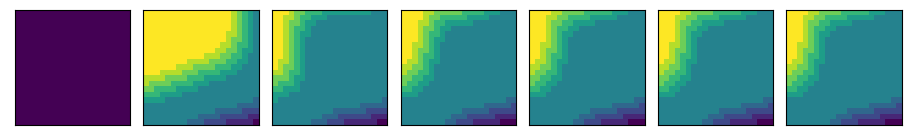

In [7]:
# Plot all policies
fig, ax = plt.subplots(1, 7, sharex=True, sharey=True, constrained_layout=True, figsize=(9, 2))
for i in range(7):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(pis[i], origin='lower')

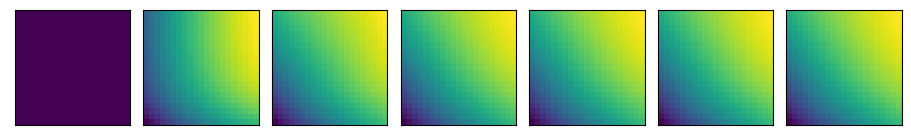

In [8]:
# Plot all value functions
fig, ax = plt.subplots(1, 7, sharex=True, sharey=True, constrained_layout=True, figsize=(9, 2))
for i in range(7):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(Vs[i], origin='lower')

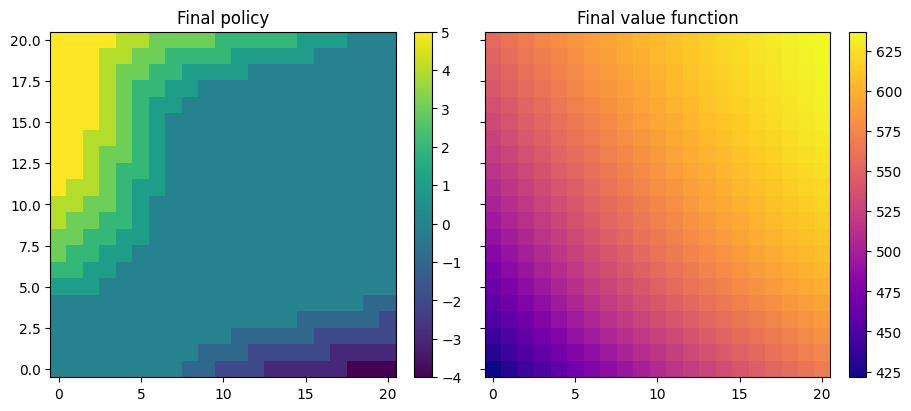

In [9]:
# Plot final policy and value function
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(9, 4))
ax[0].set_title("Final policy")
ax[1].set_title("Final value function")
I = ax[0].imshow(pi, origin='lower')
fig.colorbar(I, ax=ax[0])
I = ax[1].imshow(V, origin='lower', cmap='plasma')
fig.colorbar(I, ax=ax[1])

Now, we get to the actual exercise.

In [10]:
%%julia
using Distributions
using ProgressBars

# - MDP definition -
gamma = 0.9

# Poisson distributions
ret = (Poisson(3), Poisson(2))
req = (Poisson(3), Poisson(4))

# Rewards
rent = 10
move = -2    # though moving 1 car from 1 to 2 is free.
park = -4

# - Build transition and reward kernels -
p = zeros(21, 21, 11, 21, 21)
r = zeros(21, 21, 11)

for s1 = tqdm(0:20), s2 = 0:20
    for a in -5:5
        if !(0 <= s1 - a <= 20) || !(0 <= s2 + a <= 20)
            continue
        end

        # Move cars
        s = (s1 - a, s2 + a)
        
        # Car rentals
        for n_req1=0:s[1], n_req2=0:s[2]
            p_req1 = n_req1 < s[1] ? pdf(req[1], n_req1) : 1 - sum(pdf.(req[1], 0:(s[1] - 1)))
            p_req2 = n_req2 < s[2] ? pdf(req[2], n_req2) : 1 - sum(pdf.(req[2], 0:(s[2] - 1)))
            
            # Car returns
            for n_ret1=0:(20 - s[1] + n_req1), n_ret2=0:(20 - s[2] + n_req2)
                p_ret1 = (n_ret1 < 20 - s[1] + n_req1 ? pdf(ret[1], n_ret1) : 
                          1 - sum(pdf.(ret[1], 0:(20 - s[1] + n_req1 - 1))))
                p_ret2 = (n_ret2 < 20 - s[2] + n_req2 ? pdf(ret[2], n_ret2) : 
                          1 - sum(pdf.(ret[2], 0:(20 - s[2] + n_req2 - 1))))
              
                p[s1 + 1, s2 + 1, a + 6, s[1] - n_req1 + n_ret1 + 1, s[2] - n_req2 + n_ret2 + 1] +=
                    p_ret1 * p_req1 * p_ret2 * p_req2
                r[s1 + 1, s2 + 1, a + 6] += p_ret1 * p_req1 * p_ret2 * p_req2 * 
                    (move*((a <= 0 ? -1 : a - 1)) + rent*(n_req1 + n_req2) + (Int(s[1] >= 10) + Int(s[2] >= 10))*park)
            end
        end
        @assert abs(sum(p[s1 + 1, s2 + 1, a + 6, :, :]) - 1) < 1e-6
    end
end


0.0%┣                                               ┫ 0/21 [00:00<00:-1, -0s/it]
4.8%┣██                                         ┫ 1/21 [00:08<Inf:Inf, InfGs/it]
9.5%┣████▌                                          ┫ 2/21 [00:18<05:47, 18s/it]
14.3%┣██████▋                                       ┫ 3/21 [00:32<04:46, 16s/it]
19.0%┣████████▊                                     ┫ 4/21 [00:49<04:36, 16s/it]
23.8%┣███████████                                   ┫ 5/21 [01:09<04:37, 17s/it]
28.6%┣█████████████▏                                ┫ 6/21 [01:34<04:42, 19s/it]
33.3%┣███████████████▍                              ┫ 7/21 [02:03<04:46, 20s/it]
38.1%┣█████████████████▌                            ┫ 8/21 [02:34<04:47, 22s/it]
42.9%┣███████████████████▊                          ┫ 9/21 [03:09<04:44, 24s/it]
47.6%┣█████████████████████▍                       ┫ 10/21 [03:47<04:38, 25s/it]
52.4%┣███████████████████████▋                     ┫ 11/21 [04:28<04:28, 27s/it]
57.1%┣█████████████████████

In [11]:
%%julia
function policy_evaluation(V, pi)
    while true
        v = copy(V)
        for s1=0:20, s2=0:20
            V[s1 + 1, s2 + 1] = r[s1 + 1, s2 + 1, pi[s1 + 1, s2 + 1] + 6] + 
                gamma * sum(p[s1 + 1, s2 + 1, pi[s1 + 1, s2 + 1] + 6, :, :] .* V)
        end
        if sum(abs.(V - v)) < 1e-6
            break
        end
    end
    return V
end

function policy_improvement(V)
    pi = zeros(Int, size(V))
    for s1=0:20, s2=0:20
        pi[s1 + 1, s2 + 1] = argmax([r[s1 + 1, s2 + 1, a + 6] +
            gamma*sum(p[s1 + 1, s2 + 1, a + 6, :, :] .* V) for a in -5:5]) - 6
    end
    return pi
end

<PyCall.jlwrap policy_improvement>

In [12]:
def policy_iteration(V, pi):
    Vs = [V]
    pis = [pi]
    while True:
        v = V
        V = Main.policy_evaluation(V, pi)
        pi = Main.policy_improvement(V)
        Vs.append(V)
        pis.append(pi)
        if abs(V - v).sum() < 1e-6: break
    return V, pi, Vs, pis

In [13]:
V = np.zeros((21, 21))
pi = np.zeros((21, 21), int)

V, pi, Vs, pis = policy_iteration(V, pi)

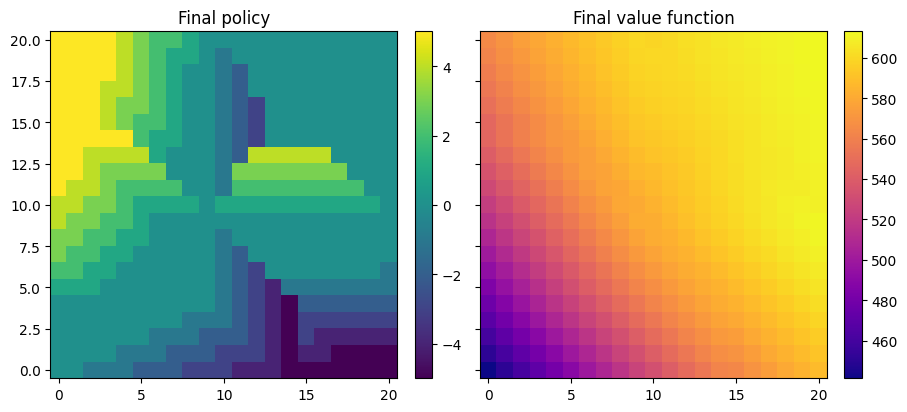

In [14]:
# Plot final policy and value function
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(9, 4))
ax[0].set_title("Final policy")
ax[1].set_title("Final value function")
I = ax[0].imshow(pi, origin='lower')
fig.colorbar(I, ax=ax[0])
I = ax[1].imshow(V, origin='lower', cmap='plasma')
fig.colorbar(I, ax=ax[1])

# Value iteration for the Gambler's Problem

In [15]:
%%julia
function value_iteration(p)
    V = zeros(101)
    while true
        v = copy(V)
        for s = 1:99
            V[s + 1] = 
                maximum([p*(Int(s + a == 100) + V[s + a + 1]) + (1 - p)*V[s - a + 1] for a = 0:min(s, 100-s)])
        end
        if sum(abs.(V - v)) < 1e-6
            break
        end
    end
    return V
end

<PyCall.jlwrap value_iteration>

In [16]:
def get_policy(p, V):
    pi = [[] for s in range(1, 100)]
    Vp = np.zeros(99)
    for s in range(1, 100):
        for a in range(1, min(s, 100-s) + 1):
            v = p*((s + a == 100) + V[s + a]) + (1 - p)*(V[s - a])
            if v > Vp[s - 1] + 1e-6:
                pi[s - 1] = [a]
                Vp[s - 1] = v
            elif v >= Vp[s - 1] - 1e-6:
                pi[s - 1].append(a)
    return [min(pi[s - 1]) for s in range(1, 100)], pi

In [17]:
p = 0.4
V = Main.value_iteration(p)
pi, pis = get_policy(p, V)

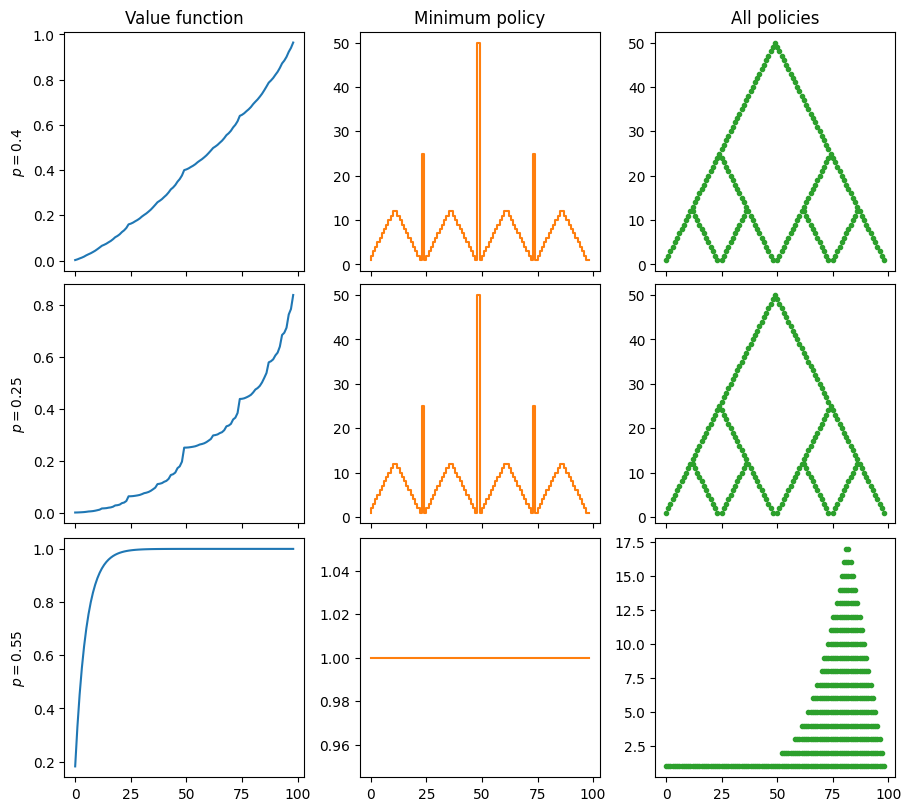

In [19]:
fig, ax = plt.subplots(3, 3, sharex=True, constrained_layout=True, figsize=(9, 8))
ax[0, 0].set_title("Value function")
ax[0, 1].set_title("Minimum policy")
ax[0, 2].set_title("All policies")

for i, p in enumerate([0.4, 0.25, 0.55]):
    ax[i, 0].set_ylabel(f"$p = {p}$")
    V = Main.value_iteration(p)
    pi, pis = get_policy(p, V)
    ax[i, 0].plot(V[1:-1])
    ax[i, 1].plot(pi, 'C1', drawstyle='steps')
    for s in range(len(pis)):
        ax[i, 2].plot([s]*len(pis[s]), pis[s], 'C2.')